In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib import colormaps as cm
import os
import glob
import gaitFunctions
from gaitFunctions import swingTimingProportions
from gaitFunctions import offsetGaitstyleLabels
from scipy import stats
import seaborn as sns

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.4
marker_color = 'k'

In [3]:
# leg relationships and colors
first_pair = ['L1','R1']
second_pair = ['L2','R2']
third_pair = ['L3','R3']
fourth_pair = ['L4','R4']
rear_legs = fourth_pair
lateral_legs = third_pair + second_pair + first_pair
ipsi_offset_legs = third_pair + second_pair
left_laterals = [x[0] for x in [third_pair, second_pair, first_pair]]
right_laterals = [x[1] for x in [third_pair, second_pair, first_pair]]
all_legs = rear_legs + lateral_legs
left_legs = [x[0] for x in [fourth_pair, third_pair, second_pair, first_pair]]
right_legs = [x[1] for x in [fourth_pair, third_pair, second_pair, first_pair]]
single_leg = ['R4']

# dictionaries of inter-leg relationships
ipsi_legs = {'L4':'L3','R4':'R3','L3':'L2','L2':'L1','R3':'R2','R2':'R1'}
contra_legs = {'L4':'R4','R4':'L4','L3':'R3','L2':'R2','R3':'L3','R2':'L2','L1':'R1','R1':'L1'}

# colors
all_leg_color = 'dimgrey'
L2_L1_color =   second_pair_color
L3_L2_color =   third_pair_color
R2_R1_color =   second_pair_color_alt
R3_R2_color =   third_pair_color_alt

In [4]:
# load data
excel_file = 'all_exemplaris_2024-04-03.xlsx'

# load the step_timing data into a dataframe
step_df = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
step_df.head(3)

,legID,DownTime,UpTime,stance,swing,gait,duty,midSwingTime,L1_mid_swings,R1_mid_swings,...,anterior_offsets,contralateral_offsets,metachronal_lag,mcl_LR_ratio,L3_bearing_change,clip,treatment,individual,date,uniq_id
0,L1,0.272,1.151,0.879,0.242,1.121,0.7841,1.2720,L1:0.8921,R1:,...,NaN,0.667,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
1,L1,1.393,2.606,1.213,0.303,1.516,0.8001,2.7575,L1:0.9001,R1:0.3701,...,NaN,1.030,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris
2,L1,2.909,4.090,1.181,0.334,1.515,0.7795,4.2570,L1:0.8898,R1:0.5597,...,NaN,0.879,NaN,NaN,NaN,iw_11Dec_exemplaris_tardigrade01_000-010,exemplaris,1,11dec,iw_11dec_tardigrade01_exemplaris


# Phase offset curves

5175 steps for ipsilateral offsets
3809 steps for contralateral offsets
1530 steps for rear offsets


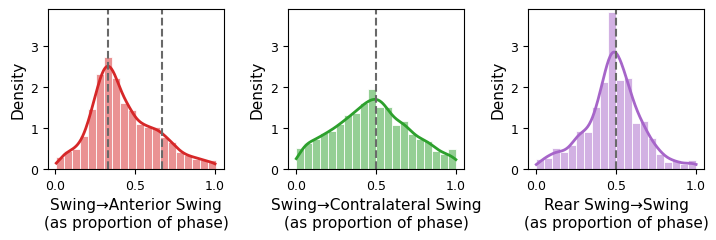

In [5]:
def offsetCurve(ax,leglist,compdict,xlab): # or 'contra' 
    # leglist = ipsi_offset_legs, left_laterals, ['L4']
    # compdict = ipsi_legs, contra_legs, contra_legs

    proportions = []
    speeds = []
    offsets = []
    for leg in leglist:
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                              step_df, leg, compdict[leg])
    
    if 'anterior' in xlab.lower():
        offset_color = ipsi_color
        desc = 'ipsilateral'
    elif 'rear' in xlab.lower():
        offset_color = rear_leg_color
        desc = 'rear'
    else:
        offset_color = contra_color
        desc = 'contralateral'
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                      color=offset_color, edgecolor='w', visible=True) # can set to False to hide bars
    print(len(proportions), 'steps for ' + desc + ' offsets')
    ax.set_xlabel(xlab)
    
    if 'anterior' in xlab.lower():
        ax.plot([1/3,1/3],[0,4],'--',color='dimgrey')
        ax.plot([2/3,2/3],[0,4],'--',color='dimgrey')
    else:
        ax.plot([1/2,1/2],[0,4],'--',color='dimgrey')
        
    return ax

f = plt.figure(figsize=(8,2))
ax1=f.add_axes([0.1,0.1,0.22,0.8])
ax2=f.add_axes([0.4,0.1,0.22,0.8])
ax3=f.add_axes([0.7,0.1,0.22,0.8])

ax1=offsetCurve(ax1,ipsi_offset_legs,ipsi_legs,'Swing→Anterior Swing\n(as proportion of phase)')
ax2=offsetCurve(ax2,left_laterals,contra_legs,'Swing→Contralateral Swing\n(as proportion of phase)')
ax3=offsetCurve(ax3,['L4'],contra_legs,'Rear Swing→Swing\n(as proportion of phase)')

# adjust parameters and plot
for ax in [ax1,ax2,ax3]:
    ax.yaxis.label.set_size(axis_fontsize)
    ax.xaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.set_ylim([0,3.9])

plt.show()

### ipsilateral offsets for individual legs

L2 : 1301 steps
L3 : 1279 steps
R2 : 1317 steps
R3 : 1278 steps


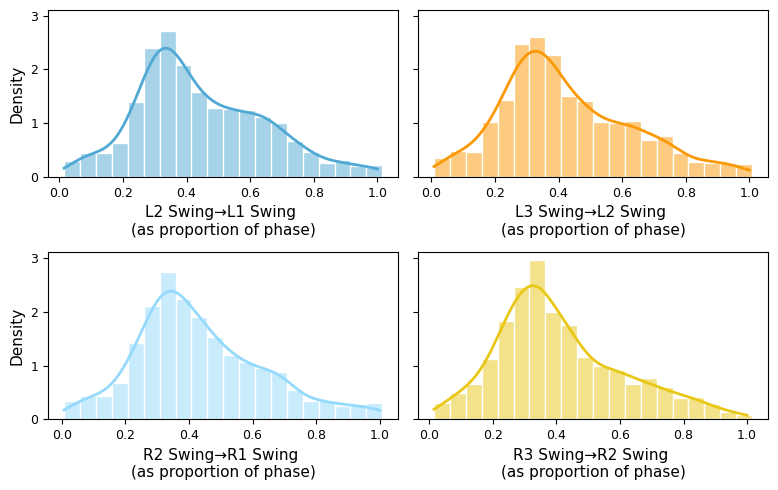

In [6]:
def plotLegOffsets(ax, df, ref_leg, test_leg, barcolor):

    proportions = []
    speeds = []
    offsets = []
    offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, 
                                                          step_df, ref_leg, test_leg)
    
    ax = sns.histplot(proportions, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                  color=barcolor, edgecolor='w', visible=True) # can set to false to hide bars
    
#     ax.set_xlabel(' --> '.join(leg_comps[i]) + ' Ipsilateral Offsets', fontsize=axis_fontsize)
    ax.set_xlabel(leg_comps[i][0] + ' Swing→' + leg_comps[i][1] + ' Swing \n(as proportion of phase)')
    
    print(leg_comps[i][0], ':', len(proportions), 'steps')
    
    return ax

f,axes = plt.subplots(2,2,figsize=(8,5), sharey=True)

leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

for i, ax in enumerate(axes.flat):
    
    ax = plotLegOffsets(ax, step_df, leg_comps[i][0], leg_comps[i][1], plot_cols[i])

    # adjust parameters
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 


plt.tight_layout()
plt.show()

L2 : 1301 steps
L3 : 1279 steps
R2 : 1317 steps
R3 : 1278 steps


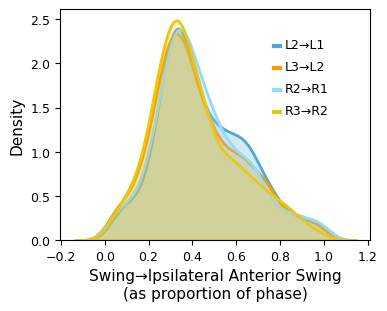

In [7]:
# ipsilateral offsets combined onto one axis
def ipsilateralOffsetIndividualLegs(ax, df, leg_comps, plot_cols, legend_fontsize, ypos=1.8, yinc = 0.3,
                                   linewidth=3):

    for i, comp in enumerate(leg_comps):
        proportions = []
        speeds = []
        offsets = []
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, df, comp[0], comp[1])

        ax = sns.kdeplot(proportions, ax=ax, color=plot_cols[i], linewidth=linewidth, fill=True)

        # klugey legend
        ax.plot([0.77,0.8],[ypos,ypos],color=plot_cols[i],linewidth=3)
        ax.text(0.82,ypos-0.03, '→'.join(comp),fontsize=tick_fontsize)
        ypos -= yinc

        print(comp[0], ':', len(proportions), 'steps')

    ax.set_xlabel('Swing→Ipsilateral Anterior Swing\n(as proportion of phase)')
    return ax

f,ax = plt.subplots(1,1,figsize=(4,3))
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]

ax = ipsilateralOffsetIndividualLegs(ax, step_df, leg_comps, plot_cols, tick_fontsize, 
                                     ypos=2.2, yinc=0.25, linewidth=2)

ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
plt.show()

### Contralateral offsets for individual legs

L1 : 1305 steps
L2 : 1251 steps
L3 : 1253 steps


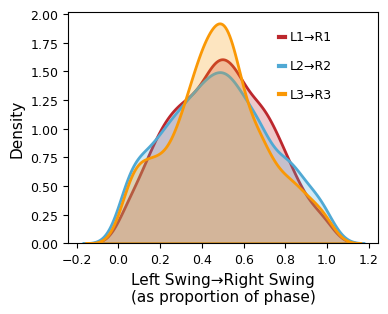

In [8]:
def contralateralOffsetIndividualLegs(ax, df, leg_comps, plot_cols, legend_fontsize, ypos=1.8, yinc = 0.3, 
                                      linewidth=3):

    for i, comp in enumerate(leg_comps):
        proportions = []
        speeds = []
        offsets = []
        offsets, proportions, speeds = swingTimingProportions(offsets, proportions, speeds, df, comp[0], comp[1])

        ax = sns.kdeplot(proportions, ax=ax, color=plot_cols[i], linewidth=linewidth, fill=True)

        # klugey legend
        ax.plot([0.77,0.8],[ypos,ypos],color=plot_cols[i],linewidth=3)
        ax.text(0.82,ypos-0.03, '→'.join(comp),fontsize=tick_fontsize)
        ypos -= yinc

        print(comp[0], ':', len(proportions), 'steps')

    ax.set_xlabel('Left Swing→Right Swing\n(as proportion of phase)')
    return ax

    
f,ax = plt.subplots(1,1,figsize=(4,3))
leg_comps = [['L1','R1'], ['L2','R2'], ['L3','R3']]
plot_cols = [first_pair_color,second_pair_color,third_pair_color]

ax = contralateralOffsetIndividualLegs(ax, step_df, leg_comps, plot_cols, tick_fontsize, 
                                       ypos=1.8, yinc=0.25, linewidth=2)

ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
plt.show()

# Figure S3

L2 : 1301 steps
L3 : 1279 steps
R2 : 1317 steps
R3 : 1278 steps
L1 : 1305 steps
L2 : 1251 steps
L3 : 1253 steps


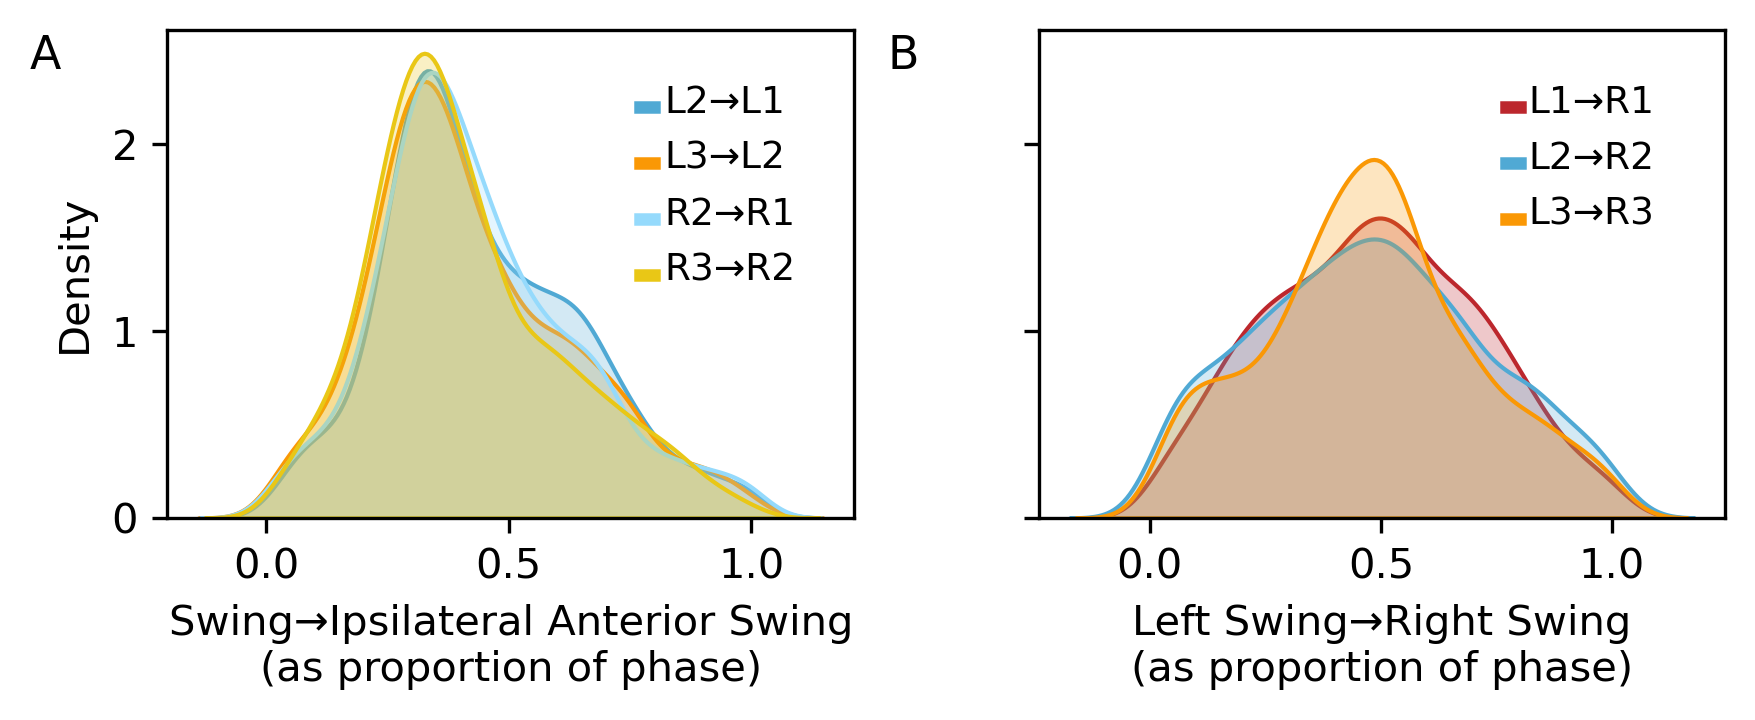

In [9]:
# ipsi and contra offsets for all lateral legs
f,[a1,a2] = plt.subplots(1,2, figsize=(6,2.5), dpi=300, sharey=True)

# ipsi
leg_comps = [['L2','L1'],['L3','L2'],['R2','R1'],['R3','R2']]
plot_cols = [L2_L1_color,L3_L2_color,R2_R1_color,R3_R2_color]
a1 = ipsilateralOffsetIndividualLegs(a1, step_df, leg_comps, plot_cols, tick_fontsize, 
                                     ypos=2.2, yinc=0.3,linewidth=1)
a1.annotate('A', xy=(-0.2, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

# contralateral offsets for each lateral leg
leg_comps = [['L1','R1'], ['L2','R2'], ['L3','R3']]
plot_cols = [first_pair_color,second_pair_color,third_pair_color]
a2 = contralateralOffsetIndividualLegs(a2, step_df, leg_comps, plot_cols, tick_fontsize, 
                                       ypos=2.2, yinc=0.3,linewidth=1)
a2.annotate('B', xy=(-0.22, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)
plt.tight_layout()
plt.show()

# sustained 2/3 offset vs. reset from gallop

In [10]:
# add normalized ipsilateral offset (offset/gait cycle) to step_df
norm_ipsi_offset = step_df['anterior_offsets'].values / step_df['gait'].values
step_df['norm_ipsi_offset'] = norm_ipsi_offset

# get 3rd leg steps where norm_ipsi_offset is close (within a buffer) to 2/3
buffer = 0.1
third_leg = step_df[step_df.legID.isin(['L3','R3'])] # third leg steps
above_buffer = third_leg[third_leg['norm_ipsi_offset'] >= 0.667 - buffer]
within_range = above_buffer[above_buffer['norm_ipsi_offset'] <= 0.667 + buffer]
print(len(within_range)) # number of third leg steps with offsets of 2/3 +/- buffer

323


num steps in "next step offset" plot: 277
num steps in "next step offset" plot: 277


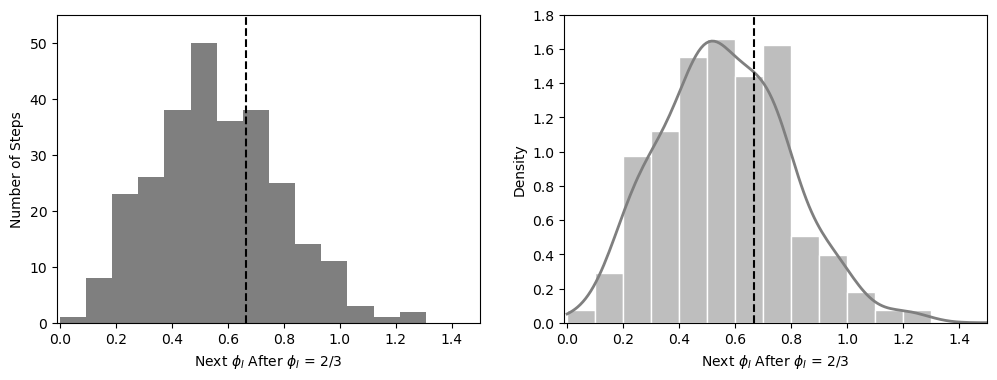

In [11]:
# for these 3rd pair leg steps with offset near 2/3, collect offsets of *next* step of same leg

steps = within_range['legID'].values
swing_starts = within_range['UpTime'].values
clips = within_range['clip'].values
norm_ipsi_offsets = within_range['norm_ipsi_offset'].values

next_step_offsets = []
no_swings = []

# each step
for i, step in enumerate(steps):
    # find next step of this leg for this clip
    clip = clips[i]
    # get swing start for this leg for this clip
    this_swing = swing_starts[i]
    # get steps for this clip
    clip_steps = step_df[step_df['clip']==clip]
    # get steps for this leg within this clip
    leg_steps = clip_steps[clip_steps['legID']==step]
    cleg_steps = leg_steps.copy()
    # sort leg_steps by UpTime
    cleg_steps.sort_values(by='UpTime',inplace=True)
    # get swing start times and normalized offsets
    uptimes = cleg_steps['UpTime'].values
    ipsi_offsets = cleg_steps['norm_ipsi_offset'].values
    # find next swing, and normalized offset for next swing
    try:
        next_up_idx = np.where(uptimes > this_swing)[0][0]
        #print(cleg_steps) # testing
        #print(uptimes) # testing
        #print(this_swing) # testing
        #print(uptimes[next_up_idx]) # testing
        #print(ipsi_offsets[next_up_idx]) # testing
        #print() # testing
        next_step_offsets.append(ipsi_offsets[next_up_idx])
    except:
        no_swings.append('No later swing for ' + clip + ' at ' + str(this_swing))

next_step_offsets = gaitFunctions.omitNan(np.array(next_step_offsets))

def nextStepOffsetPlot(ax, next_step_offsets, plottype='sns'):

    print('num steps in "next step offset" plot:',len(next_step_offsets))
    
    if plottype == 'hist':

        ymax = 55
        ax.hist(next_step_offsets,20,color='tab:gray')
        ax.plot([2/3, 2/3],[0,ymax],'--k')
        ax.set_ylim([0,ymax])
        ax.set_ylabel('Number of Steps')
    
    else:

        ymax = 1.8
        sns.histplot(next_step_offsets, ax=ax, binwidth=0.1, kde=True, stat='density',line_kws={'linewidth':2},
                          color='tab:gray', edgecolor='w', visible=True) # can set to false to hide bars
        ax.plot([2/3, 2/3],[0,ymax],'--k')
        ax.set_ylim([0,ymax])
        ax.set_ylabel('Density')
        
    ax.set_xlabel('Next $ϕ_I$ After $ϕ_I$ = 2/3')
    ax.set_xlim([-0.01,1.5])
    
    return ax

f,[ax1,ax2] = plt.subplots(1,2,figsize=(12,4))
ax1 = nextStepOffsetPlot(ax1, next_step_offsets, plottype='hist')
ax2 = nextStepOffsetPlot(ax2, next_step_offsets, plottype='sns')
        
plt.show()

# steps with ML 2793
# steps with ML 2793


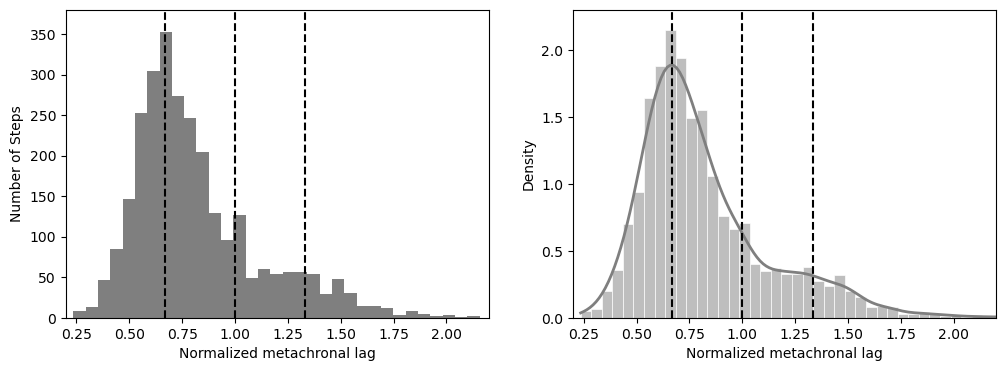

In [12]:
# add normalized ipsilateral offset (offset/gait cycle) to step_df
norm_ML = step_df['metachronal_lag'].values / step_df['gait'].values
step_df['norm_metachronal_lag'] = norm_ML
norm_ML = gaitFunctions.omitNan(np.array(norm_ML))

def mlPlot(ax,norm_ML,plottype='sns'):
    
    print('# steps with ML', len(norm_ML))
    
    if plottype == 'hist':
        ymax = 380
        ax.hist(norm_ML,50,color='tab:gray')
        ax.plot([4/3, 4/3],[0,ymax],'--k')
        ax.plot([2/3, 2/3],[0,ymax],'--k')
        ax.plot([1, 1],[0,ymax],'--k')
        ax.set_ylim([0,ymax])
        ax.set_ylabel('Number of Steps')
    else:
        pmax = 2.3
        sns.histplot(norm_ML, ax=ax, binwidth=0.05, kde=True, stat='density',line_kws={'linewidth':2},
                          color='tab:gray', edgecolor='w', visible=True) # can set to false to hide bars
        ax.plot([2/3, 2/3],[0,pmax],'--k')
        ax.plot([1, 1],[0,pmax],'--k')
        ax.plot([4/3, 4/3],[0,pmax],'--k')
        ax.set_ylim([0,pmax])
        ax.set_ylabel('Density')
        
    ax.set_xlabel('Normalized metachronal lag')
    ax.set_xlim([0.2,2.2])
    return ax
        
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1 = mlPlot(ax1,norm_ML,plottype='hist')
ax2 = mlPlot(ax2,norm_ML,plottype='sns')
plt.show()

# Metachronal Lag & turning

Num L3 steps with MCL and bearing:  1299 1299
Spearman ρ = -0.13  p =  1.24e-06


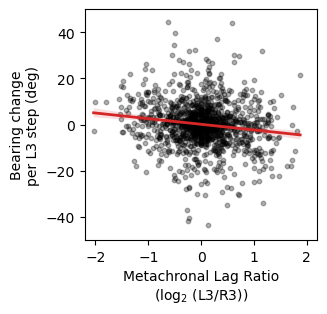

In [13]:
# Metachronal Lag vs. Bearing change
l3_bearing_changes = step_df['L3_bearing_change'].values
mcl_LR_ratio = step_df['mcl_LR_ratio'].values
l3_bearing_changes = gaitFunctions.omitNan(l3_bearing_changes)
mcl_LR_ratio = gaitFunctions.omitNan(mcl_LR_ratio)


def MLRatioBearingPlot(ax,mcl_LR_ratio,l3_bearing_changes):

    print('Num L3 steps with MCL and bearing: ', len(l3_bearing_changes),len(mcl_LR_ratio))

    sns.regplot(ax=ax, x=mcl_LR_ratio, y=l3_bearing_changes, 
                scatter_kws={'s':marker_size,'color':marker_color,'alpha':0.3}, 
                        line_kws={'color':'tab:red','linewidth':2})
    ax.set_xlabel('Metachronal Lag Ratio\n(log$_{2}$ (L3/R3))')
    ax.set_ylabel('Bearing change\nper L3 step (deg)')
    ax.set_ylim([-50,50])
    ax.set_xlim([-2.2,2.2])
    r,p = stats.spearmanr(mcl_LR_ratio,l3_bearing_changes)
    print("Spearman ρ =", np.round(r,2), " p = ", np.round(p,8))
    
    return ax

f,a = plt.subplots(1,figsize=(3,3))
a=MLRatioBearingPlot(a,mcl_LR_ratio,l3_bearing_changes)
plt.show()

# Contralateral vs. ipsilateral phases
## ϕc (Normalized Phase) vs. ϕi (Normalized Phase)

Strides:  4414


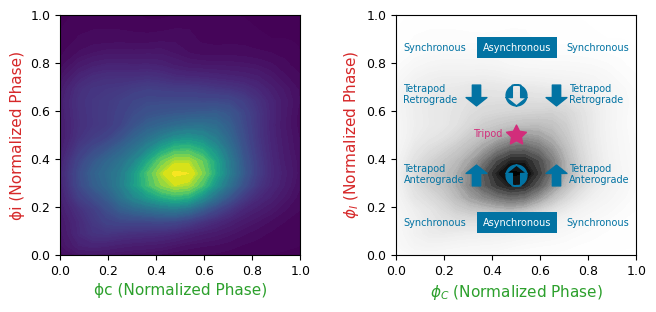

In [14]:
ipsi_swing_offset_proportions = []
contra_swing_offset_proportions = []
speeds=[]

individuals = np.sort(np.unique(step_df['uniq_id'].values))
for ref_leg in ipsi_offset_legs:
    for individual in individuals:
        individual_data = step_df[step_df['uniq_id']==individual]
        ref_leg_swings = individual_data[individual_data['legID'] == ref_leg]['UpTime'].values
        anterior_leg_swings = individual_data[individual_data['legID'] == ipsi_legs[ref_leg]]['UpTime'].values
        opposite_leg_swings = individual_data[individual_data['legID'] == contra_legs[ref_leg]]['UpTime'].values
        
        ref_leg_speeds = individual_data[individual_data['legID'] == ref_leg]['speed_during_step'].values
        ref_leg_bodylengths = individual_data[individual_data['legID'] == ref_leg]['average_tardigrade_length'].values
        
        for i, ref_swing in enumerate(ref_leg_swings[:-1]):
            next_ref_swing = ref_leg_swings[i+1]
            next_ant_idx = np.where(anterior_leg_swings>ref_swing)[0]
            next_opp_idx = np.where(opposite_leg_swings>ref_swing)[0]
            
            # add speed
            speed_during_step = ref_leg_speeds[i]
            length_during_step = ref_leg_bodylengths[i]
            
            if len(next_ant_idx) > 0 and len(next_opp_idx) > 0:
                next_ant_swing = anterior_leg_swings[next_ant_idx[0]]
                next_opp_swing = opposite_leg_swings[next_opp_idx[0]]
                
                ref_cycle = next_ref_swing-ref_swing
                
                ant_swing_offset = next_ant_swing-ref_swing
                opp_swing_offset = next_opp_swing-ref_swing
                
                ant_swing_phase_proportion = ant_swing_offset / ref_cycle
                opp_swing_phase_proportion = opp_swing_offset / ref_cycle
                
                if ant_swing_phase_proportion <= ref_cycle and opp_swing_phase_proportion < ref_cycle:
                    ipsi_swing_offset_proportions.append(ant_swing_phase_proportion) 
                    contra_swing_offset_proportions.append(opp_swing_phase_proportion)
                    speeds.append(speed_during_step/length_during_step)

ipsi_phase = np.array(ipsi_swing_offset_proportions)
cont_phase = np.array(contra_swing_offset_proportions)
print('Strides: ', len(ipsi_phase))

f = plt.figure(figsize=(8,3))
ax1 = f.add_axes([0.1,0.1,0.38,0.8])
ax2 = f.add_axes([0.52,0.1,0.38,0.8], sharex=ax1, sharey=ax1)

ax1 = sns.kdeplot(ax=ax1, x=cont_phase, y=ipsi_phase, fill=True, cmap='viridis', thresh=0, levels=60)
ax2 = sns.kdeplot(ax=ax2, x=cont_phase, y=ipsi_phase, fill=True, cmap='Greys', thresh=0, levels=60) # Greys or binary

for ax in [ax1,ax2]:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('ϕc (Normalized Phase)', fontsize=axis_fontsize, color=contra_color)
    ax.set_ylabel('ϕi (Normalized Phase)', fontsize=axis_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax2=offsetGaitstyleLabels(ax2, True, 7) # False for no text
plt.show()

# % tetrapod or tripod canonical vs. Coordination Strength

Tetrapod points 103
Tripod points   31
Tetrapod ρ = 0.17 p = 0.08
Tripod   ρ = 0.26 p = 0.16


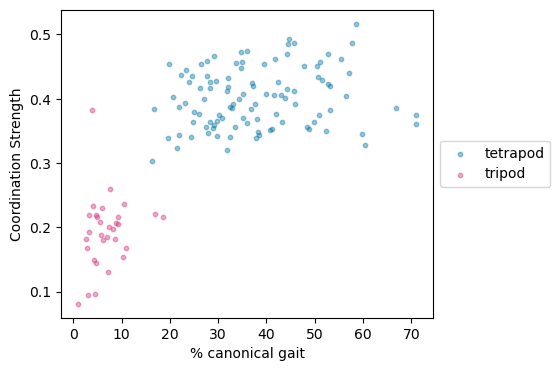

In [15]:
# in gait_summaries we have % tetrapod or tripod canonical for each individual
# in gait_summaries we also have tetrapod and tripod coordination strength
# make scatter plot of these
# should only include individuals where coordination strength score is based on > threshold number of bouts

# First we will get # of bouts per tardigrade ... 
# can get this info from gait_speeds sheet
gait_speeds_df = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)

individuals = np.unique(gait_speeds_df['uniq_id'].values)
num_tetrapod_bouts = np.zeros(len(individuals))
num_tripod_bouts = np.zeros(len(individuals))
for i, individual in enumerate(individuals):
    tet_bouts = gait_speeds_df[gait_speeds_df.uniq_id == individual]['tetrapod_coordination'].values
    tet_bouts = gaitFunctions.omitNan(tet_bouts)
    # print(individual, len(tet_bouts)) # testing OK, all have at least 15 bouts
    num_tetrapod_bouts[i] = len(tet_bouts)
    
    tri_bouts = gait_speeds_df[gait_speeds_df.uniq_id == individual]['tripod_coordination'].values
    tri_bouts = gaitFunctions.omitNan(tri_bouts)
    # print(individual, len(tri_bouts)) # testing OK ... only 31 have at least 5 bouts; 63 have at least 2
    num_tripod_bouts[i] = len(tri_bouts)
    
tet_boutnum_dict = dict(zip(individuals, num_tetrapod_bouts))
tri_boutnum_dict = dict(zip(individuals, num_tripod_bouts))

# Next, we will get percentages of frames in canonical tetrapod or tripod 
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
# print(gait_df.columns)
identifiers = gait_df['Identifier'].values
tet_css_dict = dict(zip(identifiers, gait_df['Tetrapod Coordination Strength'].values))
tri_css_dict = dict(zip(identifiers, gait_df['Tripod Coordination Strength'].values))
tet_perc_dict = dict(zip(identifiers, gait_df['% tetrapod canonical (lateral legs)'].values))
tri_perc_dict = dict(zip(identifiers, gait_df['% tripod canonical (lateral legs)'].values))

# define minimum threshold number of bouts to consider
tet_threshold = 15 # all 103 tardigrades have more than 15 bouts of canonical tetrapod
tri_threshold = 5 # 31 tardigrades have 5 or more bouts of canonical tripod; 63 have 2 or more

# tetrapod scatter data
tet_x = [tet_perc_dict[x] for x in identifiers if tet_boutnum_dict[x] >= tet_threshold]
tet_y = [tet_css_dict[x] for x in identifiers if tet_boutnum_dict[x] >= tet_threshold]

# tripod scatter data
tri_x = [tri_perc_dict[x] for x in identifiers if tri_boutnum_dict[x] >= tri_threshold]
tri_y = [tri_css_dict[x] for x in identifiers if tri_boutnum_dict[x] >= tri_threshold]

# report number of points plotted
print('Tetrapod points', len(tet_x))
print('Tripod points  ', len(tri_x))

# get plot colors
combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

# setup figure and plot
f,a = plt.subplots(1,1,figsize=(6,4))

a.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')

a.set_xlabel('% canonical gait')
a.set_ylabel('Coordination Strength')

# add a legend to right of axis
# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# run and report some statistics
tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()

# Bout Speed vs. Coordination Strength

Tetrapod ρ = 0.04 p = 0.71
Tripod   ρ = 0.05 p = 0.67


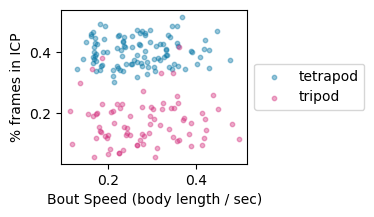

In [28]:
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)

f,a = plt.subplots(1,1,figsize=(3,2))

tet_x = gait_df['Tetrapod Bout Speed (bodylength / s)'].values
tet_y = gait_df['Tetrapod Coordination Strength'].values
tri_x = gait_df['Tripod Bout Speed (bodylength / s)'].values
tri_y = gait_df['Tripod Coordination Strength'].values
tri_x = tri_x[np.where(~np.isnan(tri_x))]
tri_y = tri_y[np.where(~np.isnan(tri_x))]
tri_x = tri_x[np.where(~np.isnan(tri_y))]
tri_y = tri_y[np.where(~np.isnan(tri_y))]

combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

a.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
a.set_xlabel('Bout Speed (body length / sec)')
a.set_ylabel('% frames in ICP')

# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()

# Bout Speed vs. % tetrapod or tripod canonical

Tetrapod ρ = 0.71 p = 0.0
Tripod   ρ = 0.17 p = 0.12


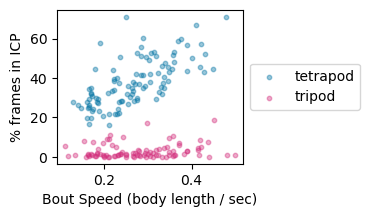

In [24]:
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)

f,a = plt.subplots(1,1,figsize=(3,2))

tet_x = gait_df['Tetrapod Bout Speed (bodylength / s)'].values
tet_y = gait_df['% tetrapod canonical (lateral legs)'].values
tri_x = gait_df['Tripod Bout Speed (bodylength / s)'].values
tri_y = gait_df['% tripod canonical (lateral legs)'].values
tri_x = tri_x[np.where(~np.isnan(tri_x))]
tri_y = tri_y[np.where(~np.isnan(tri_x))]

combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
tetra_color = combo_colors['tetrapod_canonical']
tripod_color = combo_colors['tripod_canonical']

a.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
a.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
a.set_xlabel('Bout Speed (body length / sec)')
a.set_ylabel('% frames in ICP')

# Shrink current axis by 20%
box = a.get_position()
a.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
a.legend(loc='center left', bbox_to_anchor=(1, 0.5))

tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))

plt.show()


# Coordination Consistency Score
## steps in tetrapod ICP / total steps (for each leg or all legs)

# ICP Composition Plots

Number of individuals here:  103


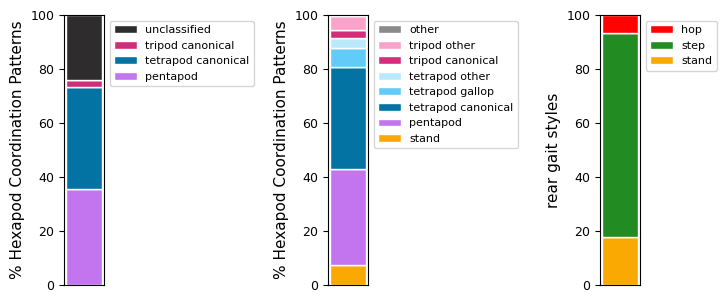

Values to match Nirody paper ... tripod: 2.7%; tetrapod: 37.8%; pentapod: 35.5%; unclassified: 23.9%


Nirody paper vals =               tripod: 3%,  tetrapod: 31%,   pentapod: 10%


In [29]:
hexapod_combos, hexapod_color_dict = gaitFunctions.get_gait_combo_colors('hexapod')
bipod_combos, bipod_color_dict = gaitFunctions.get_gait_combo_colors('bipod')

# load gait data from gait_styles sheet
gait_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
num_individuals = len(gait_df['% pentapod (lateral legs)'].values)
print('Number of individuals here: ', num_individuals)

# Nirody reported values for hexapod gait (and hex colors)
pentapod = np.mean(gait_df['% pentapod (lateral legs)'].values) # color = #d22d7b
tetrapod_canonical = np.mean(gait_df['% tetrapod canonical (lateral legs)'].values) #009bdd
tripod_canonical = np.mean(gait_df['% tripod canonical (lateral legs)'].values) #5d257e
unclassified = 100 - (pentapod + tetrapod_canonical + tripod_canonical) #181818

# Rest of the values for hexapod gait (and adjacent colors)
stand = np.mean(gait_df['% stand (lateral legs)'].values) #bf1717
tetrapod_gallop = np.mean(gait_df['% tetrapod gallop (lateral legs)'].values) #a4ddf5
tetrapod_other = np.mean(gait_df['% tetrapod other (lateral legs)'].values) #caecfa
tripod_other = np.mean(gait_df['% tripod other (lateral legs)'].values) #c292de
other = np.mean(gait_df['% other (lateral legs)'].values) #8a8a8a

# Values for rear legs
rear_stand = np.mean(gait_df['% stand (rear legs)'].values)
rear_step = np.mean(gait_df['% step (rear legs)'].values)
rear_hop = np.mean(gait_df['% hop (rear legs)'].values)

# set up figure
f = plt.figure(figsize=(8,3))
hexapod_ylab = '% Hexapod Coordination Patterns'

# Nirody hexapod categories
ax1 = f.add_axes([0.05,0.05,0.05,0.9])
groups = [['exemplaris']]
n_categories = ['pentapod','tetrapod canonical','tripod canonical','unclassified']
n_proportions = [[pentapod, tetrapod_canonical, tripod_canonical, unclassified]]
n_plot_colors = [hexapod_color_dict[x.replace(' ','_')] for x in n_categories]
ax1 = gaitFunctions.percentagesPlotWithLegend(ax1, groups, n_categories, n_proportions, 
                                              n_plot_colors, hexapod_ylab)

# All hexapod categories
ax2 = f.add_axes([0.38,0.05,0.05,0.9])
a_categories = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
              'tripod canonical','tripod other','other']
a_proportions = [[stand, pentapod, tetrapod_canonical, tetrapod_gallop, tetrapod_other,
                tripod_canonical, tripod_other, other]]
a_plot_colors = [hexapod_color_dict[x.replace(' ','_')] for x in a_categories]
ax2 = gaitFunctions.percentagesPlotWithLegend(ax2, groups, a_categories, a_proportions, 
                                              a_plot_colors, hexapod_ylab)

# Rear categories
ax3 = f.add_axes([0.72,0.05,0.05,0.9]) 
r_categories = ['stand','step','hop']
r_proportions = [[rear_stand, rear_step, rear_hop]]
r_plot_colors = [bipod_color_dict[x] for x in r_categories]
ax3 = gaitFunctions.percentagesPlotWithLegend(ax3, groups, r_categories, r_proportions, 
                                              r_plot_colors, 'rear gait styles')

summary = 'Values to match Nirody paper ... '
summary += ('tripod: ' + str(np.round(tripod_canonical,1)) + '%; ')
summary += ('tetrapod: ' + str(np.round(tetrapod_canonical,1)) + '%; ')
summary += ('pentapod: ' + str(np.round(pentapod,1)) + '%; ')
summary += ('unclassified: ' + str(np.round(unclassified,1)) + '%')

for ax in [ax1,ax2,ax3]:
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)

plt.show()
print(summary)
print('\n')
print('Nirody paper vals =               tripod: 3%,  tetrapod: 31%,   pentapod: 10%')

# Figure 4

5175 steps for ipsilateral offsets
3809 steps for contralateral offsets
1530 steps for rear offsets
Tetrapod ρ = 0.04 p = 0.71
Tripod   ρ = 0.05 p = 0.67
num steps in "next step offset" plot: 277
# steps with ML 2793
Num L3 steps with MCL and bearing:  1299 1299
Spearman ρ = -0.13  p =  1.24e-06


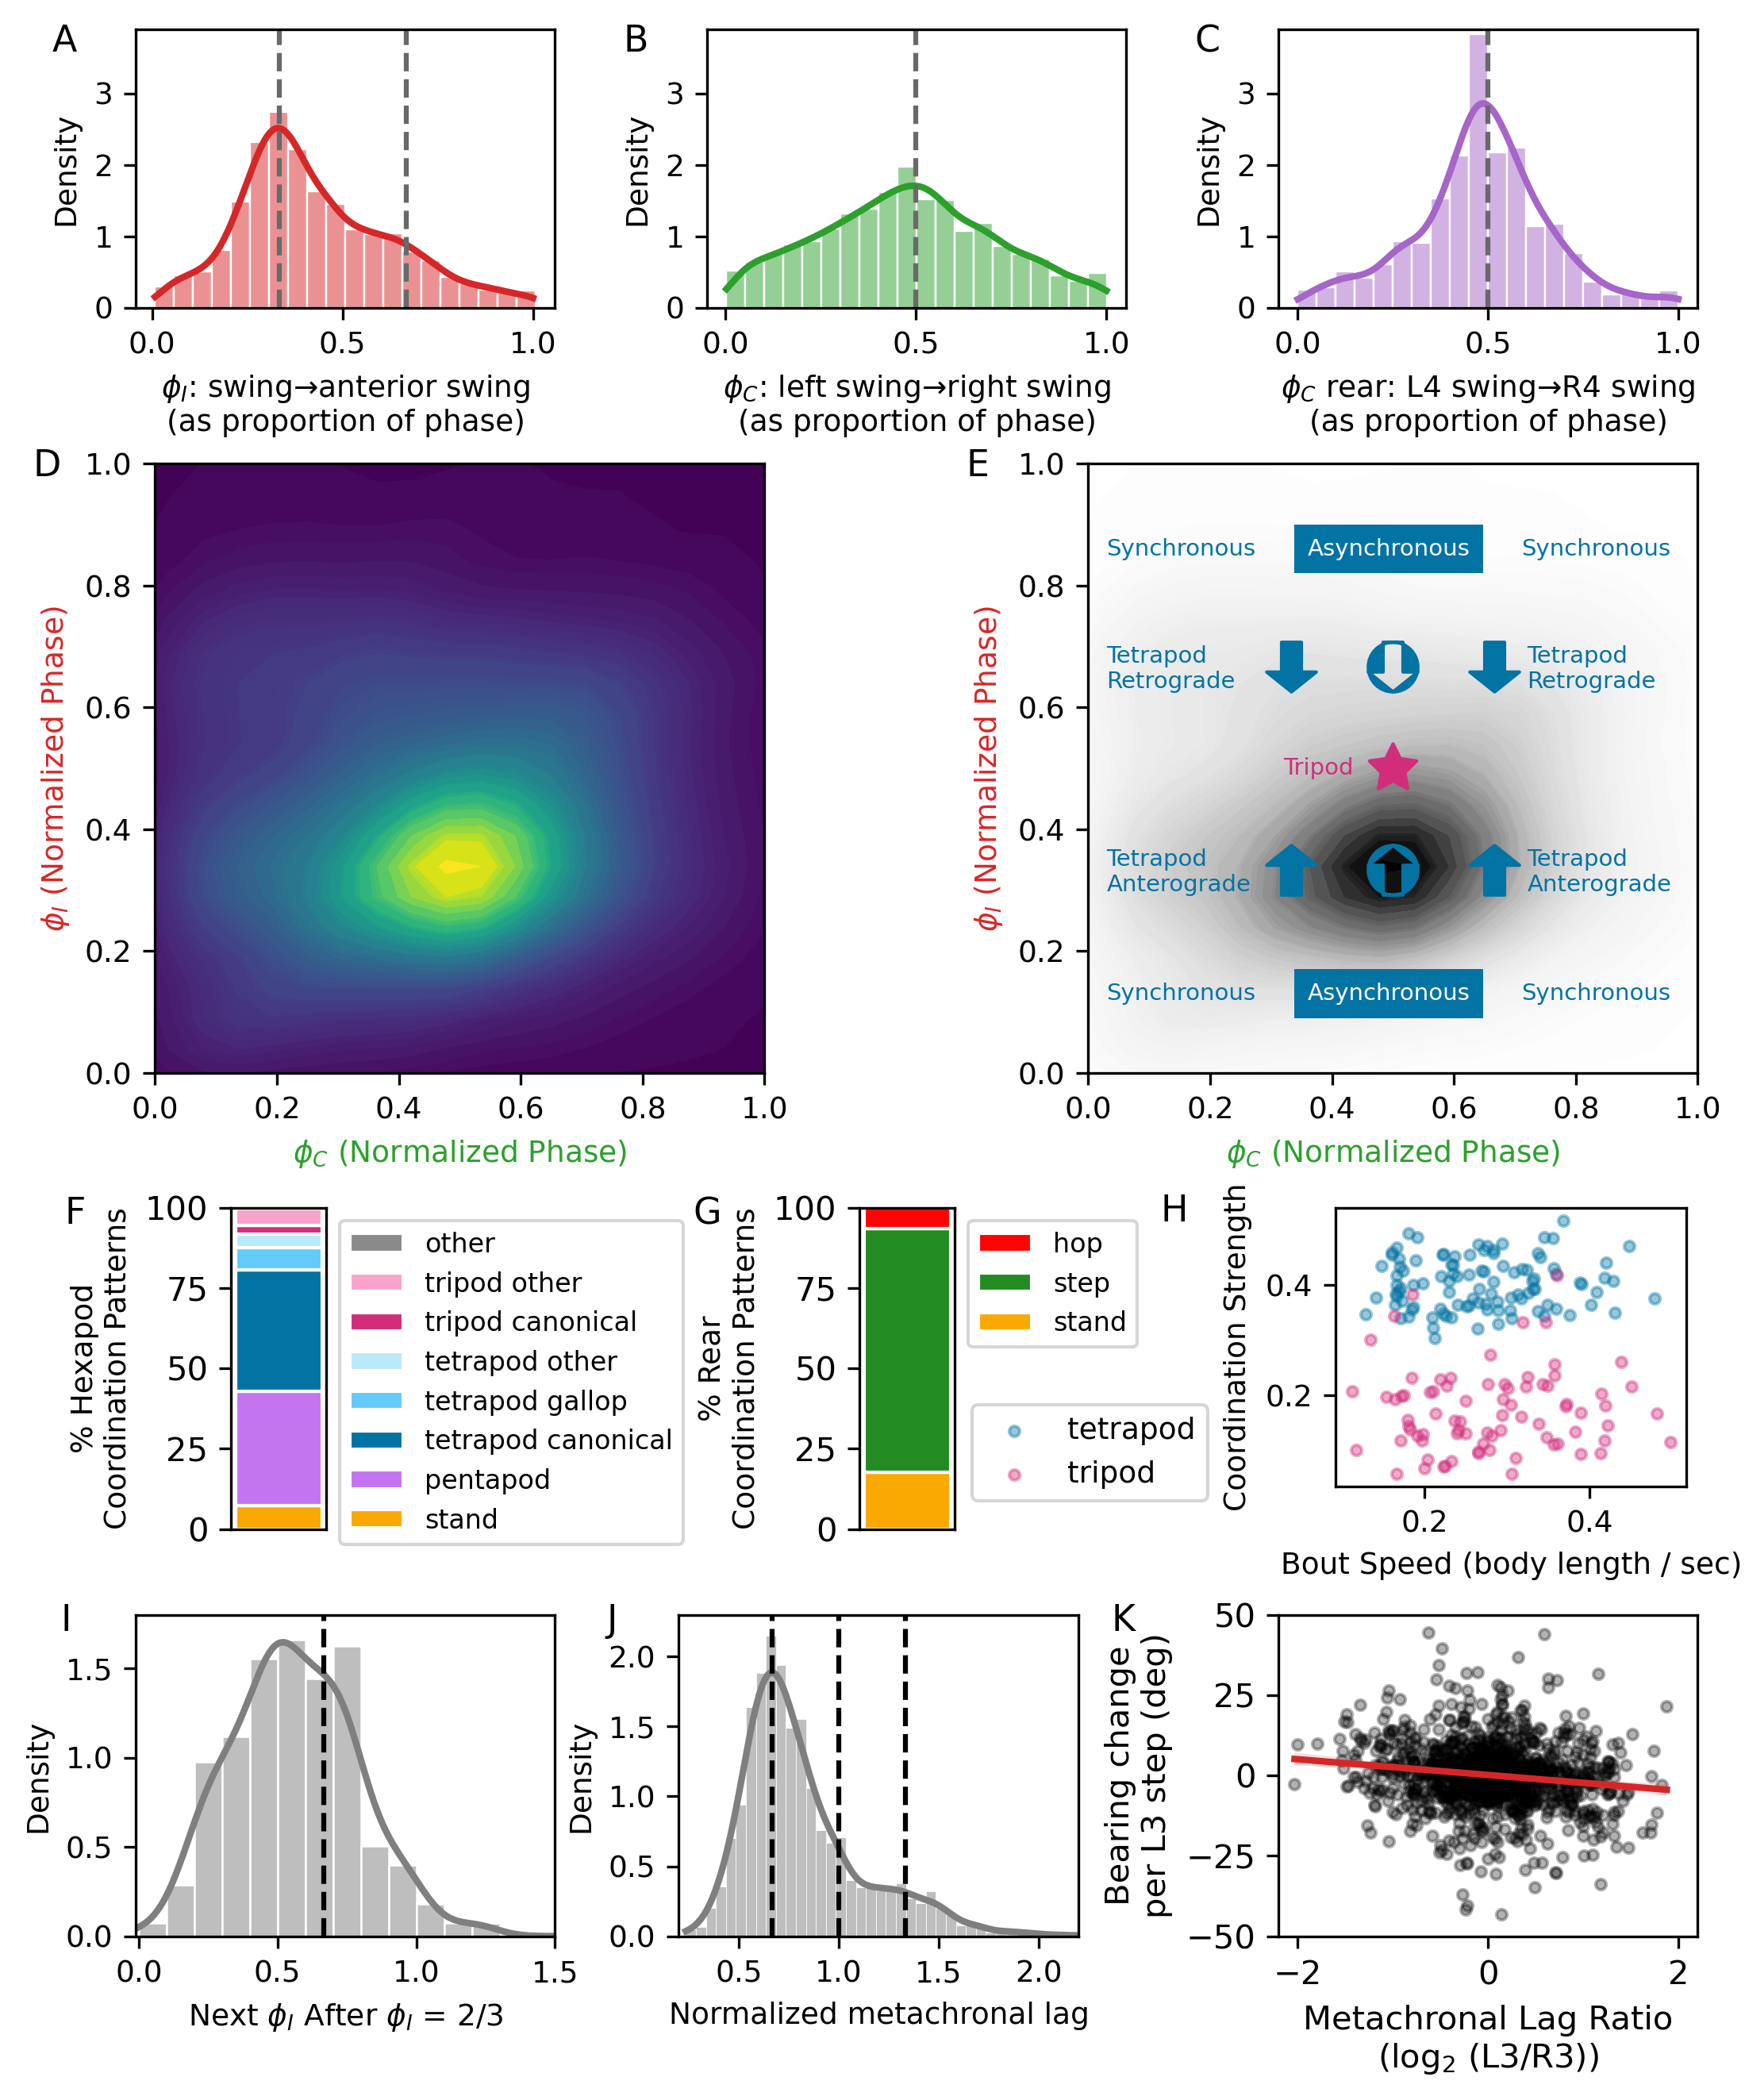

In [30]:
f = plt.figure(figsize = (8,9),dpi=300)

# offsets
ipsi_ax = f.add_axes(  [0.1, 0.82,0.22,0.13])
contra_ax = f.add_axes([0.4, 0.82,0.22,0.13])
rear_ax = f.add_axes(  [0.7, 0.82,0.22,0.13])
ipsi_ax=offsetCurve(ipsi_ax,ipsi_offset_legs,ipsi_legs,'$ϕ_I$: swing→anterior swing\n(as proportion of phase)')
contra_ax=offsetCurve(contra_ax,left_laterals,contra_legs,'$ϕ_C$: left swing→right swing\n(as proportion of phase)')
rear_ax=offsetCurve(rear_ax,['L4'],contra_legs,'$ϕ_C$ rear: L4 swing→R4 swing\n(as proportion of phase)')

# ϕc x ϕi heatmaps
heatmap_ax = f.add_axes ([0.11,  0.445, 0.32, 0.32])
arrowmap_ax = f.add_axes([0.60,  0.445, 0.32, 0.32], sharex=heatmap_ax, sharey=heatmap_ax)
heatmap_ax = sns.kdeplot(ax=heatmap_ax, x=cont_phase, y=ipsi_phase, fill=True, cmap='viridis', thresh=0, levels=50)
arrowmap_ax = sns.kdeplot(ax=arrowmap_ax, x=cont_phase, y=ipsi_phase, fill=True, cmap='Greys', thresh=0, levels=50) # Greys or binary
arrowmap_ax=offsetGaitstyleLabels(arrowmap_ax, True, 7) # False for no text

# gait style proportions
hexgait_ax = f.add_axes( [0.15, 0.25, 0.05,  0.15])
reargait_ax = f.add_axes([0.48, 0.25, 0.05,  0.15])
hexgait_ax = gaitFunctions.percentagesPlotWithLegend(hexgait_ax, groups, a_categories, 
                                                 a_proportions, a_plot_colors, 
                                                 '% Hexapod\nCoordination Patterns')
reargait_ax = gaitFunctions.percentagesPlotWithLegend(reargait_ax, groups, r_categories, 
                                                      r_proportions, r_plot_colors,
                                                      '% Rear\nCoordination Patterns')

cs_ax = f.add_axes(       [0.73, 0.27, 0.23, 0.13])
cs_ax.scatter(tet_x,tet_y,s=marker_size,alpha=marker_alpha,c=tetra_color,label='tetrapod')
cs_ax.scatter(tri_x,tri_y,s=marker_size,alpha=marker_alpha,c=tripod_color,label='tripod')
cs_ax.set_xlabel('Bout Speed (body length / sec)', fontsize=tick_fontsize)
cs_ax.set_ylabel('Coordination Strength', fontsize=tick_fontsize)
cs_ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# Shrink current axis by 20%
box = cs_ax.get_position()
cs_ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the left of the axis
cs_ax.legend(loc='center left', bbox_to_anchor=(-1.08, 0.12), fontsize=tick_fontsize)

tet_r,tet_p = stats.spearmanr(tet_x,tet_y)
tri_r,tri_p = stats.spearmanr(tri_x,tri_y)
print('Tetrapod ρ =', np.round(tet_r,2), 'p =', np.round(tet_p,2))
print('Tripod   ρ =', np.round(tri_r,2), 'p =', np.round(tri_p,2))


# 3 across bottom
next_offset =     f.add_axes(       [0.100, 0.06, 0.22, 0.15])
metachronal_lag = f.add_axes(       [0.385, 0.06, 0.21, 0.15])
turning =         f.add_axes(       [0.700, 0.06, 0.22, 0.15])

next_offset = nextStepOffsetPlot(next_offset, next_step_offsets, plottype='sns')
metachronal_lag = mlPlot(metachronal_lag,norm_ML,plottype='sns')
turning = MLRatioBearingPlot(turning,mcl_LR_ratio,l3_bearing_changes)

# adjust parameters and plot
letters = ['A','B','C']
for i,ax in enumerate([ipsi_ax,contra_ax,rear_ax]):
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.set_ylim([0,3.9])
    ax.annotate(letters[i], xy=(-0.2, 0.92), xycoords='axes fraction', fontsize=axis_fontsize)

letters = ['D','E']
for i, ax in enumerate([heatmap_ax,arrowmap_ax]):
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('$ϕ_C$ (Normalized Phase)', fontsize=tick_fontsize, color=contra_color)
    ax.set_ylabel('$ϕ_I$ (Normalized Phase)', fontsize=tick_fontsize, color=ipsi_color)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.annotate(letters[i], xy=(-0.2, 0.98), xycoords='axes fraction', fontsize=axis_fontsize)

letters = ['F','G']
for i, ax in enumerate([hexgait_ax, reargait_ax]):
    ax.yaxis.label.set_size(tick_fontsize)
    ax.annotate(letters[i], xy=(-1.75, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)

cs_ax.annotate('H', xy=(-0.5, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)

letters = ['I','J']
for i,ax in enumerate([next_offset,metachronal_lag]):
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize) 
    ax.annotate(letters[i], xy=(-0.18, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)

turning.annotate('K', xy=(-0.4, 0.95), xycoords='axes fraction', fontsize=axis_fontsize)    

plt.show()

# Interleg coordination violin plots

In [31]:
gait_summaries_df = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
gait_summaries_df.head(3)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR pentapod (lateral legs),CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs)
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,538,11.152416,50.371747,24.721190,7.992565,5.390335,...,0.521226,-0.278867,-0.017608,0.184165,-1.607393,-5.378522,-1.490361,-0.118556,0.114893,-0.897491
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,564,3.014184,31.737589,31.737589,14.716312,5.319149,...,0.059297,-0.029026,0.592837,0.170871,-0.401826,1.268835,-1.490361,0.267112,-0.014541,0.249235
2,iw_11dec_tardigrade03_exemplaris,exemplaris,tardigrade03,11dec,506,16.600791,44.466403,27.667984,4.743083,4.545455,...,0.396530,-0.166252,-0.539433,0.013686,-1.546071,-0.777312,-1.490361,0.728694,-0.108547,-1.529317


In [32]:
# print(gait_summaries_df.columns)
columns_to_analyze = [
    '% stand (lateral legs)', 
    '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
    '% tetrapod gallop (lateral legs)', 
    '% tetrapod other (lateral legs)',
    '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
    '% tripod other (lateral legs)', 
    '% tripod total (lateral legs',
#     '% other (lateral legs)', 
    '% stand (rear legs)', 
    '% hop (rear legs)',
    '% step (rear legs)', 
    'Tetrapod Coordination Strength',
    'Tripod Coordination Strength',
    'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Bout Speed (bodylength / s)'
]
print(len(columns_to_analyze))

16


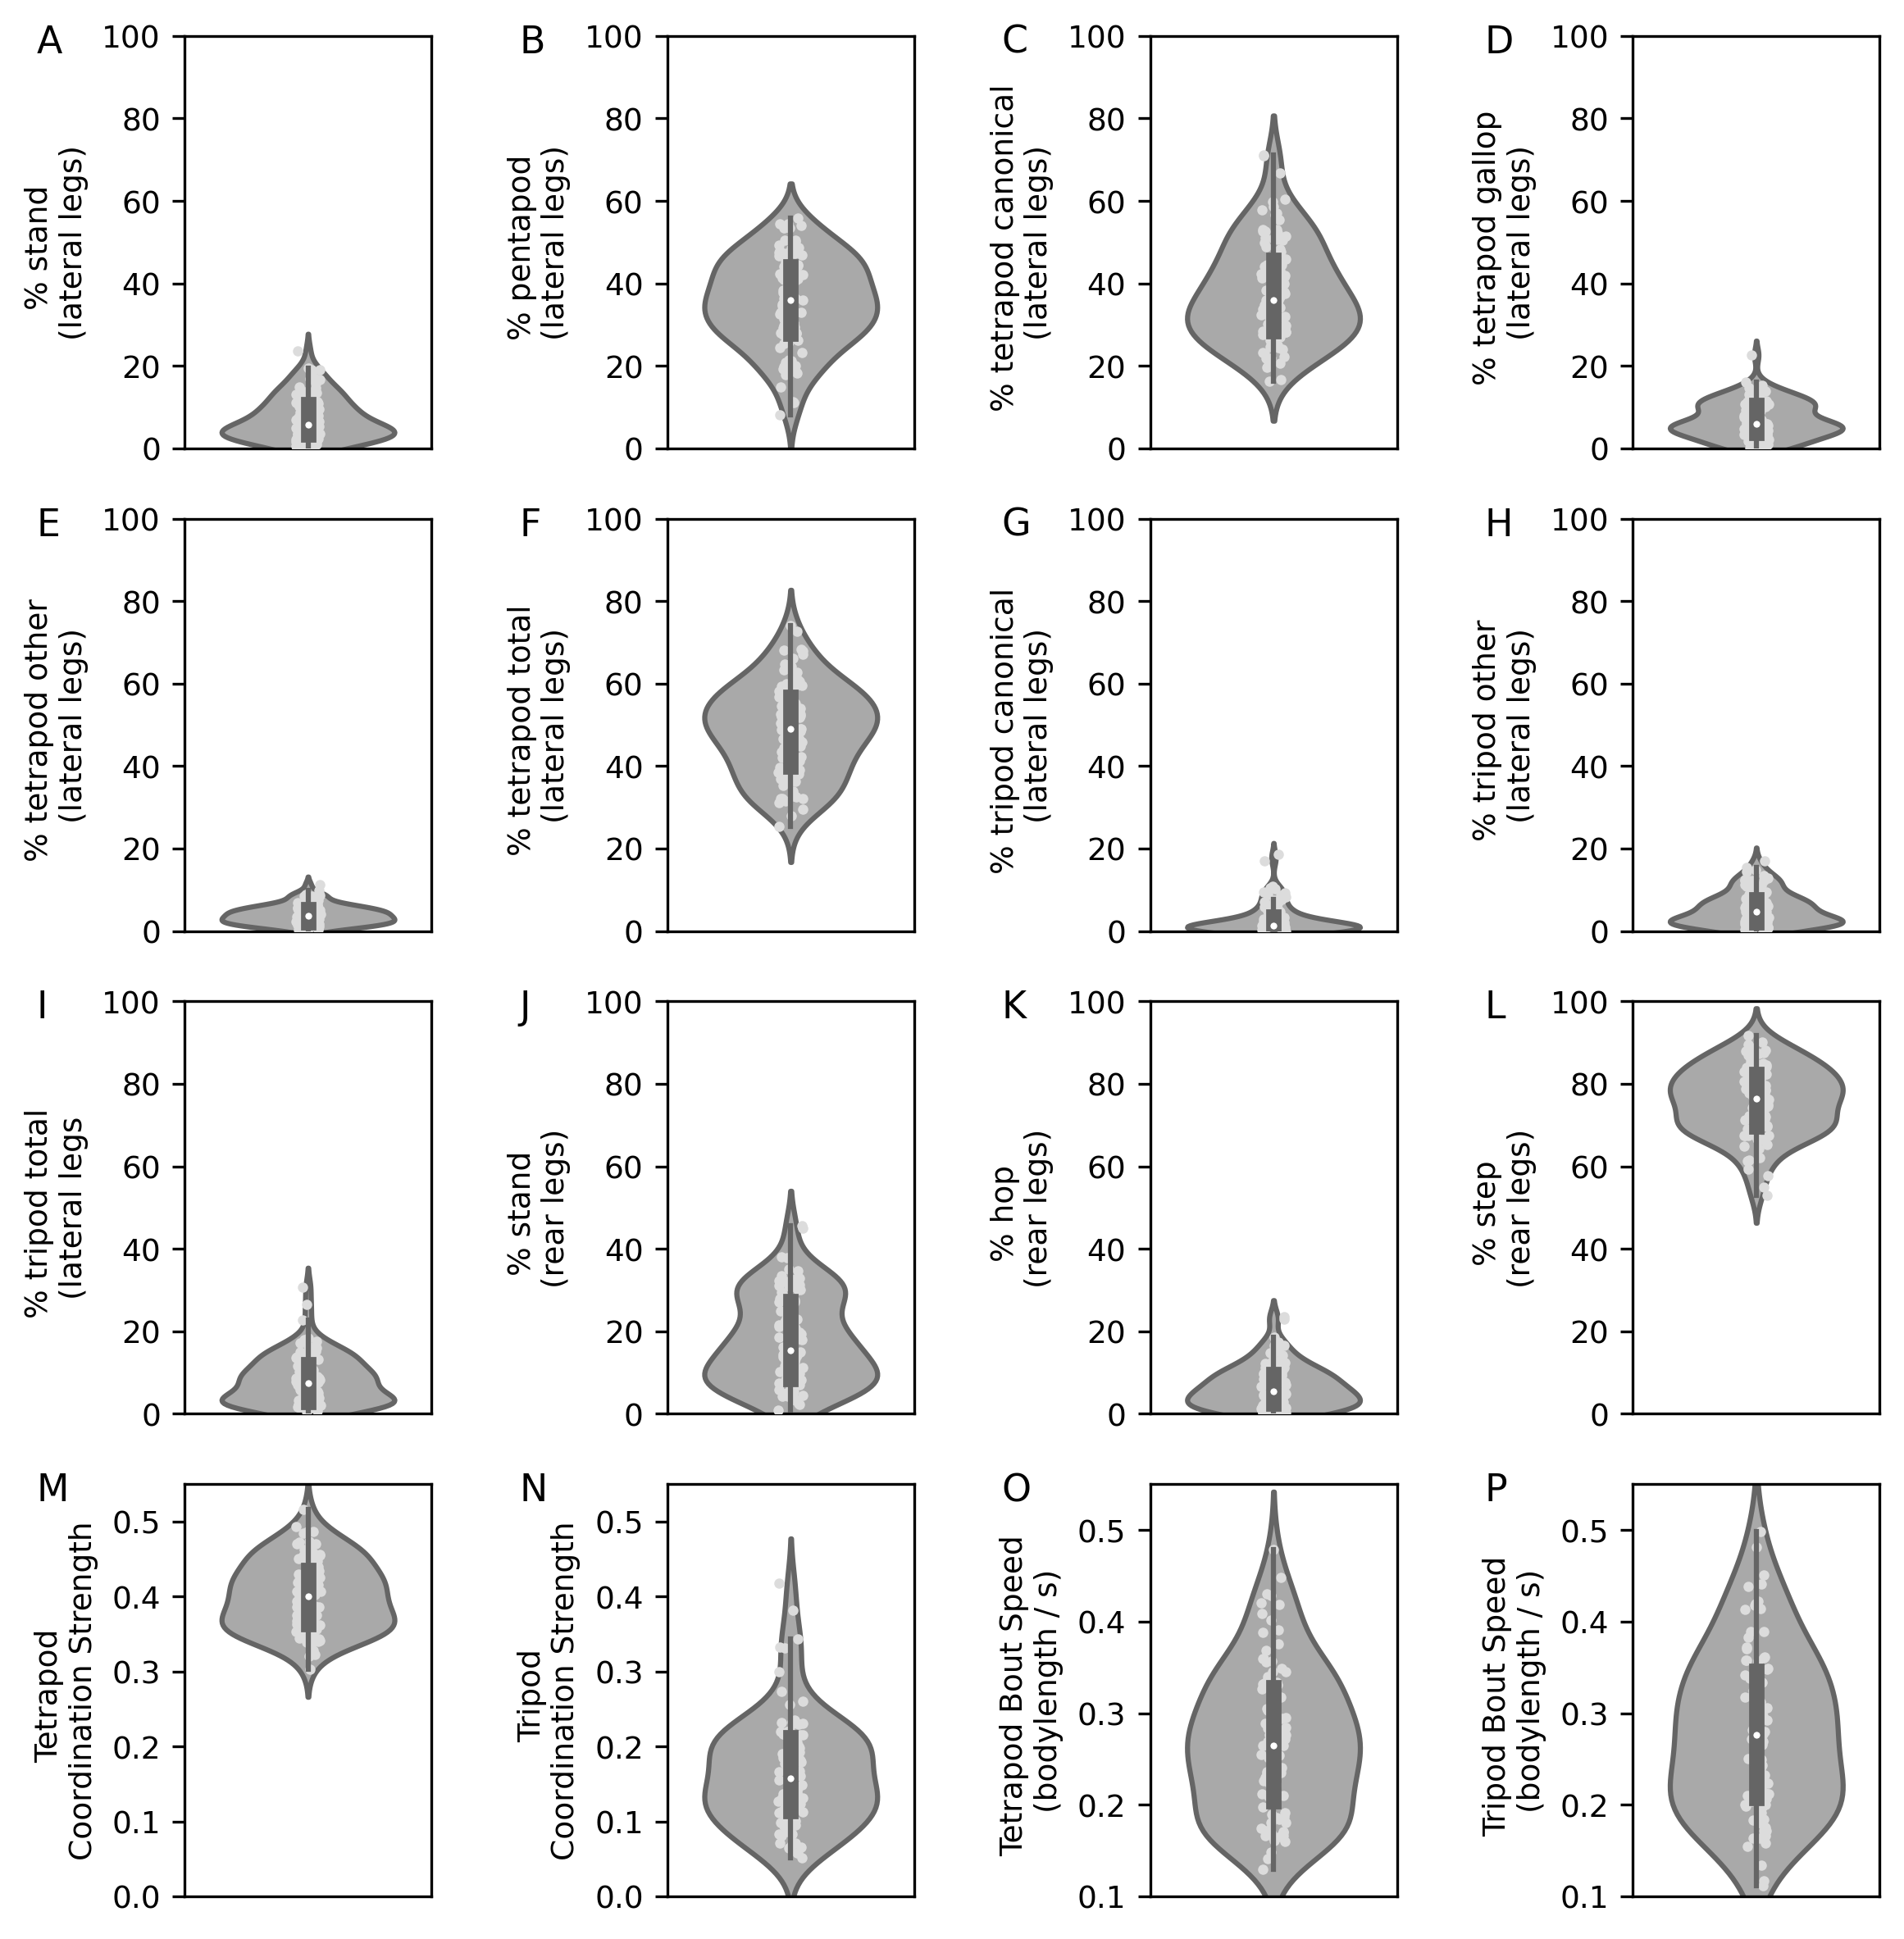

In [33]:
rows,cols = [4,4]
f,axes = plt.subplots(rows,cols,figsize = (8,8), dpi=300)
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleViolinPoints(axes_list[i], gait_summaries_df, col, box=True, vwidth=0.7,
                                                   vcolor='darkgray',pointcolor='gainsboro')
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    lab = col
    lab = lab.replace('(','\n(')
    lab = lab.replace('Coordination','\nCoordination')
    axes_list[i].yaxis.label.set_text(lab)
    if lab[0] == '%':
        axes_list[i].set_ylim([0,100])
    elif 'Coordination Strength' in lab:
        axes_list[i].set_ylim([0,0.55])
    elif 'Bout Speed' in lab:
        axes_list[i].set_ylim([0.1, 0.55])
    axes_list[i].annotate(letters[i], xy=(-0.6, 0.96), xycoords='axes fraction', fontsize=axis_fontsize)
plt.tight_layout()
plt.show()

# Measurements of Interleg Coordination --> Table S1

In [ ]:
# # Table as an excel file ... 
# out_file = 'Interleg_Coordination.xlsx'
# with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
#     summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='Interleg Coordination')